In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path
ROOT = Path('/content/drive/MyDrive/universite-paris-saclay/nlp/rottentomatoes')

In [ ]:
!pip install transformers
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pathlib import Path
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from wordcloud import WordCloud
from transformers import BertModel, BertTokenizer
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import langdetect
import random
import nltk
import gensim
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [ ]:
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# Let's get started with BERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Create a function to tokenize a set of texts
def preprocessing_for_bert(data, max_len):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text = sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=max_len,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
reviews_df = pd.read_csv(ROOT / "preprocessed_reviews.csv")

# Sample just the 10% of the data
perc = 0.5
reviews_df = reviews_df.sample(frac=perc, random_state=2023)

X = reviews_df['review_content'].values
y = reviews_df['review_type'].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.1, random_state=2023)

X_train, X_val, y_train, y_val =\
    train_test_split(X_train, y_train, test_size=0.1, random_state=2024)

# Tokenize the input text

# From the histogram above we saw that all the reviews
# are shorter than 30 tokens.
max_len = 30

# Run function `preprocessing_for_bert` on the train set, the validation set and the test set
train_inputs, train_masks = preprocessing_for_bert(X_train, max_len)
val_inputs, val_masks = preprocessing_for_bert(X_val, max_len)
test_inputs, test_masks = preprocessing_for_bert(X_test, max_len)

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
test_labels = torch.tensor(y_test)

# For fine-tuning BERT, it's recommended a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=1)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
class BertForSentimentAnalysis(nn.Module):
    def __init__(self, bert_model):
        super().__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, 2) # 768 is the output dimension of BERT model
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [ ]:
def train(model, train_dataloader, optimizer, criterion):
    model.train()
    total_loss, total_acc = 0, 0
    for step, batch in enumerate(train_dataloader):
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy_score(torch.argmax(logits, axis=1).cpu().numpy(), labels.cpu().numpy())
    return total_loss/len(train_dataloader), total_acc/len(train_dataloader)


def evaluate(model, val_dataloader, criterion):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for step, batch in enumerate(val_dataloader):
            input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
            logits = model(input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            total_acc += accuracy_score(torch.argmax(logits, axis=1).cpu().numpy(), labels.cpu().numpy())
    return total_loss/len(val_dataloader), total_acc/len(val_dataloader)

In [ ]:
model = BertForSentimentAnalysis(bert_model)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

In [ ]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

num_epochs = 5
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_dataloader, criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Training Accuracy: {train_acc:.4f} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_acc:.4f}')


Epoch 1/5 - Training Loss: 0.5431 - Training Accuracy: 0.7234 - Validation Loss: 0.4568 - Validation Accuracy: 0.7712
Epoch 2/5 - Training Loss: 0.3481 - Training Accuracy: 0.8540 - Validation Loss: 0.4341 - Validation Accuracy: 0.7977
Epoch 3/5 - Training Loss: 0.1810 - Training Accuracy: 0.9349 - Validation Loss: 0.6855 - Validation Accuracy: 0.7386
Epoch 4/5 - Training Loss: 0.0987 - Training Accuracy: 0.9692 - Validation Loss: 0.7833 - Validation Accuracy: 0.7652
Epoch 5/5 - Training Loss: 0.0709 - Training Accuracy: 0.9756 - Validation Loss: 0.6895 - Validation Accuracy: 0.7814


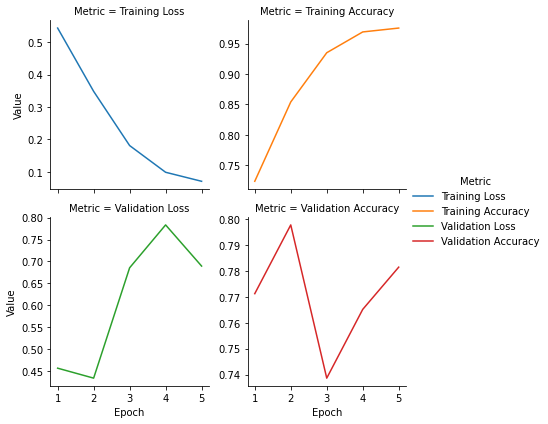

In [ ]:
data = {
    'Epoch': range(1, num_epochs+1),
    'Training Loss': train_losses,
    'Training Accuracy': train_accs,
    'Validation Loss': val_losses,
    'Validation Accuracy': val_accs
}
trends = pd.DataFrame(data)

trends = trends.melt(id_vars=['Epoch'], var_name='Metric', value_name='Value')

# Create a facet grid with subplots for each metric
g = sns.FacetGrid(trends, col='Metric', hue='Metric', col_wrap=2, sharey=False)
g.map(sns.lineplot, 'Epoch', 'Value')

# Set the axis labels and legend
g.set_axis_labels('Epoch', 'Value')
g.add_legend()

# Show the plot
plt.show()

In [ ]:
torch.save(model.state_dict(), ROOT / "bert-rottentomatoes-binary-05-v3.pth")

In [ ]:
class BertForSentimentAnalysis(nn.Module):
    def __init__(self, bert_model):
        super().__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, 2) # 768 is the output dimension of BERT model
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [ ]:
bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
bert_binary = BertForSentimentAnalysis(bert_model)
bert_binary.load_state_dict(torch.load(ROOT / "bert-rottentomatoes-binary-05-v3.pth"))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
bert_binary.to(device)

In [ ]:
def predict(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()
    predictions=[]
    # Tracking variables
    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()
        predictions.append(int(preds.detach().cpu().numpy()))

    return predictions

In [ ]:
predictions = predict(bert_binary, test_dataloader)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.84      0.71      0.77       286
           1       0.75      0.87      0.81       293

    accuracy                           0.79       579
   macro avg       0.79      0.79      0.79       579
weighted avg       0.79      0.79      0.79       579



In [ ]:
def custom_test(model, text):
    inputs = tokenizer(text, return_tensors='pt')

    # Make a prediction with the model
    outputs = model(inputs['input_ids'], inputs['attention_mask'])
    predicted_class = torch.argmax(outputs[0])

    # Print the predicted sentiment
    if predicted_class == 1:
        # print('Fresh')
        return 'Fresh'
    else:
        # print('Rotten')
        return 'Rotten'

In [ ]:
bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
bert_binary = BertForSentimentAnalysis(bert_model)
bert_binary.load_state_dict(torch.load(ROOT / "bert-rottentomatoes-binary-05-v2.pth"))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
def preprocess_text(text):
    # Removing numerical data or irrelevant characters
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Tokenization
    tokens = nltk.word_tokenize(text)
    # Lowercasing
    tokens = [token.lower() for token in tokens]
    # Removing stopwords
    tokens = [token for token in tokens if token not in stopwords.words("english")]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Joining the tokens back to a string
    text = " ".join(tokens)
    return text

In [ ]:
reviews = pd.read_csv(ROOT / "clean_reviews.csv")
reviews = reviews.sample(50)
print(reviews.columns)
# print(reviews)
for r in reviews.iterrows():
    _, r = r
    review_type, review_score, review_content = r
    # print(r)eview_type, review_score, review_content = r
    print('REVIEW:')
    print(review_content)
    print('True type:', 'Rotten' if review_type == 0 else 'Fresh')
    print('Prediction:', custom_test(bert_binary, preprocess_text(review_content)))


Index(['review_type', 'review_score', 'review_content'], dtype='object')
REVIEW:
Puerile writing, confused plotting and shockingly off-note performances make Oliver Stone's epic film a disappointment.
True type: Rotten
Prediction: Rotten
REVIEW:
Frankly, us geeks have never had it so good: Scott Pilgrim Vs The World is modern cinema at its most exciting, and it belongs to us.
True type: Fresh
Prediction: Fresh
REVIEW:
Space Chimps tries to please both kids and parents with a queasy mix of rapid-fire, Looney Tunes-y slapstick and sly pop culture references, but the surprisingly flat animation and tired jokes keep it from ever leaving orbit.
True type: Rotten
Prediction: Rotten
REVIEW:
This Barbershop may not provide you a soapbox or a good fade, but it'll definitely leave you with a warm and fuzzy feeling.
True type: Fresh
Prediction: Fresh
REVIEW:
For fans of the show, even with all of its faults, the movie has many laugh-out-loud scenes and is a guilty pleasure
True type: Fresh
Predic